In [1]:
import sys
import gym
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict, deque

# Blackjack
In this notebook we will implement an agent for playing Blackjack, using Monte Carlo control to learn a good policy. 

In [2]:
env = gym.make('Blackjack-v0')

## Setting up
We define an Agent class with an action space of 2, and attributes epsilon, epsilon_d (decay), epsilon_m (minimum epsilon) alpha learning rate and gamma discounting factor. The agent also has a Q-table, which we initialise as a dictionary. In this situation, this is more practical than a numpy array because some states are impossible to visit during the game of Blackjack.

We define two Agent class methods, one for selecting an action according to an epsilon-greedy policy, and the other for updating the Agent's Q-table using Monte Carlo. MC is a good approach for solving this problem because each episode of Blackjack has **only a few timesteps**. For that reason, Temporal Difference methods would not constitute an advantage.

In [6]:
class Agent():
    
    def __init__(self, nA=2, epsilon=1, epsilon_d=0.99999, epsilon_m = 0.05, alpha=0.015, gamma=1.0):
        self.nA = nA
        self.epsilon = epsilon
        self.epsilon_d = epsilon_d
        self.epsilon_m = epsilon_m
        self.alpha = alpha
        self.gamma = gamma
        self.Q = defaultdict(lambda: np.zeros(nA))
        
    def select_action(self, state):
        probabilities = np.ones(self.nA)*self.epsilon/self.nA
        greedy_action = np.argmax(self.Q[state]) if state in self.Q else env.action_space.sample()
        probabilities[greedy_action] = 1 - self.epsilon + (self.epsilon/self.nA)
        action = np.random.choice(self.nA, p=probabilities)
        return action
    
    def MC_update(self, states, actions, rewards):
        discounts = np.array([self.gamma**1 for i in range(len(rewards)+1)])
        for i, state in enumerate(states):
            old_Q = self.Q[state][actions[i]]
            self.Q[state][actions[i]] = old_Q + self.alpha*(sum(rewards[i:]*discounts[:-(1+i)]) - old_Q)

Then we define a function for agent-environment interaction, *MC_blackjack*, which, for a number of episodes, initiates lists to keep track of states, actions and rewards for the episode and coordinates the Agent's methods for selecting an action based on a state and Q-table, then updates the agent's Q-table at the end of the episode, based on its outcome. The function returns the learnt Q-table and policy.

In [7]:
def MC_blackjack(env, agent, num_episodes, window=1000):
    for i_episode in range(1, num_episodes+1):
        states = []
        actions = []
        rewards = []
        agent.epsilon = max(agent.epsilon*agent.epsilon_d, agent.epsilon_m)
        state = env.reset()
        while True:
            action = agent.select_action(state)
            next_state, reward, done, info = env.step(action)
            states.append(state)
            actions.append(action)
            rewards.append(reward)
            state = next_state
            if done:
                agent.MC_update(states, actions, rewards)
                break
                
        if i_episode % window == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
                
    policy = dict((k,np.argmax(v)) for k, v in agent.Q.items())
    
    return agent.Q, policy

## Learning a good policy and plotting the results
We're ready to instantiate our agent and use our *MC_blackjack* function to get it to learn a good policy by interacting with the environment.

In [8]:
agent = Agent()
Q, policy = MC_blackjack(env, agent, num_episodes=10000000)

Episode 10000000/10000000.

### Q-table
We now visualise the Q-table learnt by our agent. States in the Blackjack environment are tuples of dimension 3 (Player's current sum, Dealer's showing card and whether we have a usable ace or not). To be able to visualise our results in 2D, I opted to split the Q-table in two (Usable Ace or not) and representing Q values in color.

The first block of code sets up two Q-table arrays from the Q dictionary and the second block sets up a subplot, with axes, etc appropriately labeled.

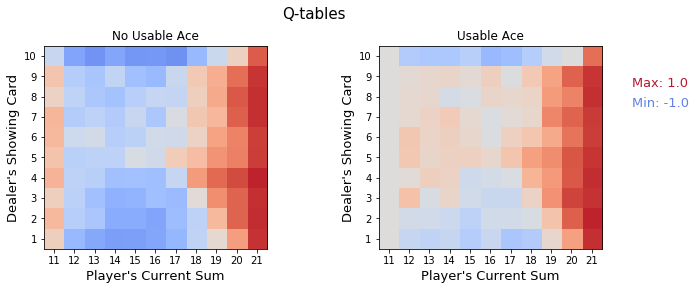

In [9]:
Q_array_noAce = np.zeros((11,10))
Q_array_Ace = np.zeros((11,10))

for x in np.arange(11, 22):
    for y in np.arange(10, 0, -1):
        if (x,y,False) in Q:
            Q_array_noAce[x-11,y-1] = np.max(np.array([Q[x,y,False]]))
        else:
            pass
        if (x,y,True) in Q:
            Q_array_Ace[x-11,y-1] = np.max(np.array([Q[x,y,True]]))
        else:
            pass

Q_array_noAce = Q_array_noAce.T
Q_array_Ace = Q_array_Ace.T

fig, (ax1, ax2) = plt.subplots(1,2, sharex=False, sharey=False, figsize = (10,20))

plt.setp((ax1,ax2), xticks=np.arange(11), xticklabels=np.arange(11,22),
        yticks=np.arange(10), yticklabels=np.arange(10, 0, -1))
plt.subplots_adjust(wspace=0.5)
plt.suptitle('Q-tables',y=0.6, fontsize=15)

ax1.imshow(Q_array_noAce, cmap='coolwarm', vmin = -1, vmax = 1)
ax1.set_xlabel("Player's Current Sum", fontsize=13);
ax1.set_ylabel("Dealer's Showing Card", fontsize=13);
ax1.set_title('No Usable Ace');

ax2.imshow(Q_array_Ace, cmap='coolwarm', vmin = -1, vmax = 1)
ax2.set_ylabel("Dealer's Showing Card", fontsize=13);
ax2.set_xlabel("Player's Current Sum", fontsize=13);
ax2.set_title('Usable Ace');
ax2.text(12,1.5,'Max: 1.0', color=(184/255,24/255,46/255), fontsize=13);
ax2.text(12,2.5,'Min: -1.0', color=(98/255,130/255,229/255), fontsize=13);

### Policy
Now we do the same thing to visualise the policy learnt by our agent. The true optimal policy is overlaid on the heatmap as a dashed line for comparison.

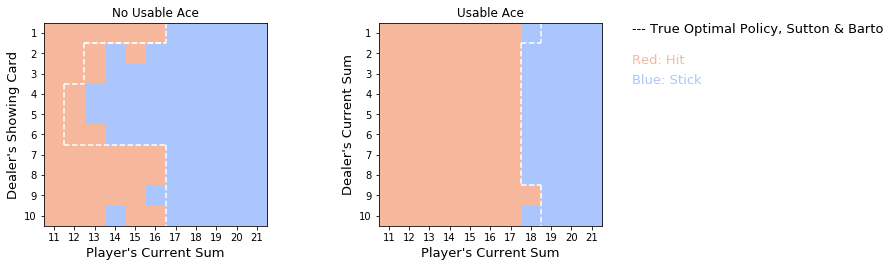

In [10]:
p_array_noAce = np.ones((11,10))
p_array_Ace = np.ones((11,10))

for x in np.arange(11, 22):
    for y in np.arange(10, 0, -1):
        if (x,y,False) in policy:
            p_array_noAce[x-11,y-1] = policy[x,y,False]
        else:
            pass
        if (x,y,True) in policy:
            p_array_Ace[x-11,y-1] = policy[x,y,True]
        else:
            pass

p_array_noAce = p_array_noAce.T
p_array_Ace = p_array_Ace.T

fig, (ax1, ax2) = plt.subplots(1,2, sharex=False, sharey=False, figsize = (10,20))

plt.setp((ax1,ax2), xticks=np.arange(11), xticklabels=np.arange(11,22),
        yticks=np.arange(11), yticklabels=np.arange(1, 11, 1))
plt.subplots_adjust(wspace=0.5)

ax1.imshow(p_array_noAce, cmap='coolwarm', vmin = -1, vmax = 2)
ax1.set_xlabel("Player's Current Sum", fontsize=13);
ax1.set_ylabel("Dealer's Showing Card", fontsize=13);
ax1.set_title('No Usable Ace');
ax1.vlines(x=5.5, ymin=5.5, ymax=9.5,colors='w', linestyles={'dashed'});
ax1.vlines(x=5.5, ymin=-0.5, ymax=0.5,colors='w', linestyles={'dashed'});
ax1.vlines(x=1.5, ymin=0.5, ymax=2.5,colors='w', linestyles={'dashed'});
ax1.vlines(x=0.5, ymin=2.5, ymax=5.5,colors='w', linestyles={'dashed'});
ax1.hlines(y=0.5, xmin=1.5 , xmax=5.5,colors='w', linestyles={'dashed'});
ax1.hlines(y=0.5, xmin=1.5 , xmax=5.5,colors='w', linestyles={'dashed'});
ax1.hlines(y=5.5, xmin=0.5 , xmax=5.5,colors='w', linestyles={'dashed'});
ax1.hlines(y=2.5, xmin=0.5 , xmax=1.5,colors='w', linestyles={'dashed'});

ax2.imshow(p_array_Ace, cmap='coolwarm', vmin = -1, vmax = 2)
ax2.set_ylabel("Dealer's Current Sum", fontsize=13);
ax2.set_xlabel("Player's Current Sum", fontsize=13);
ax2.set_title('Usable Ace');
ax2.vlines(x=7.5, ymin=-0.5, ymax=0.5,colors='w', linestyles={'dashed'});
ax2.vlines(x=6.5, ymin=0.5, ymax=7.5,colors='w', linestyles={'dashed'});
ax2.vlines(x=7.5, ymin=7.5, ymax=9.5,colors='w', linestyles={'dashed'});
ax2.hlines(y=0.5, xmin=6.5, xmax=7.5, colors='w', linestyles={'dashed'});
ax2.hlines(y=7.5, xmin=6.5, xmax=7.5, colors='w', linestyles={'dashed'});
ax2.text(12,0,'--- True Optimal Policy, Sutton & Barto', fontsize=13);
ax2.text(12,1.5,'Red: Hit', color=(245/255,183/255,159/255), fontsize=13);
ax2.text(12,2.5,'Blue: Stick', color=(171/255,198/255,250/255), fontsize=13);

In [11]:
def just_play_blackjack(env, agent, num_episodes, window=1000):
    won = 0
    drew = 0
    lost = 0
    for i_episode in range(1, num_episodes+1):
        #states = []
        #actions = []
        #rewards = []
        agent.epsilon = 0
        state = env.reset()
        while True:
            action = agent.select_action(state)
            next_state, reward, done, info = env.step(action)
            #states.append(state)
            #actions.append(action)
            #rewards.append(reward)
            state = next_state
            if done:
                if reward == 1:
                    won += 1
                elif reward == 0:
                    drew += 1
                elif reward == -1:
                    lost += 1
                break

    print('Played {} games of blackjack: won {}%, lost {}% and drew {}%.'.format(num_episodes,
                                                                                 round(100*won/num_episodes,1),
                                                                                 round(100*lost/num_episodes,1),
                                                                                 round(100*drew/num_episodes,1)))
                
    return (won, drew, lost)

Above we define a function for playing blackjack greedily (with an epsilon of 0) and not updating the Q-table. Let's see how well the agent fares.

In [13]:
results = just_play_blackjack(env,agent,num_episodes=50000)

Played 50000 games of blackjack: won 42.4%, lost 48.1% and drew 9.5%.
